In [1]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [46]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import display as IPdisplay, Image as IPImage
from PIL import Image

In [3]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

/home/james/anaconda2/envs/nolearn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')

Using lasagne.layers (slower)


In [5]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    try:
        testfile = urllib.request.URLopener()
    except:
        testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set

In [6]:
# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
X = np.reshape(X, (-1, 1, 28, 28))
print('X type and shape:', X.dtype, X.shape)
print('X.min():', X.min())
print('X.max():', X.max())

X type and shape: float32 (50000, 1, 28, 28)
X.min(): 0.0
X.max(): 0.996094


In [7]:
# we need our target to be 1 dimensional
X_out = X.reshape((X.shape[0], -1))
print('X_out:', X_out.dtype, X_out.shape)

X_out: float32 (50000, 784)


In [8]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [9]:
ae = NeuralNet(
    layers=layers,
    max_epochs=25,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [10]:
ae.fit(X, X_out)

# Neural Network with 224177 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  input0       1x28x28
  1  conv2d1      16x26x26
  2  conv2d2      16x24x24
  3  maxpool2d3   16x12x12
  4  conv2d4      32x10x10
  5  maxpool2d5   32x5x5
  6  reshape6     800
  7  dense7       128
  8  encode       16
  9  dense9       128
 10  dense10      800
 11  reshape11    32x5x5
 12  upscale2d12  32x10x10
 13  conv2d13     16x12x12
 14  upscale2d14  16x24x24
 15  conv2d15     16x26x26
 16  conv2d16     1x28x28
 17  reshape17    784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.06714       0.05103      1.31560  207.36s
      2       0.04241       0.03554      1.19347  208.26s
      3       0.03248       0.02972      1.09317  256.08s
      4       0.02875       0.02722      1.05599  291.00s
      5       0.02667       0.02547      1.04699  281.32s
      6       0.02514    

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fbd40250210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fbd40250110>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne....d': 'full', 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=25, more_params={},
     objective=<function objective at 0x7fbd40252f50>,
     objective_loss_function=<function squared_error at 0x7fbd41484b90>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fbd4020b560>],
     on_training_finished=[],
     on_training_st

<module 'matplotlib.pyplot' from '/home/james/anaconda2/envs/nolearn/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

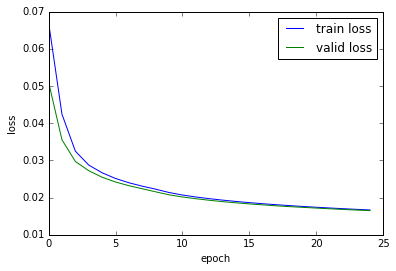

In [11]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [12]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('mnist/conv_ae.pkl','wb'))
# ae = pickle.load(open('mnist/conv_ae.pkl','rb'))
# ae.layers

In [13]:
X_pred = ae.predict(X).reshape(-1, 28, 28)
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print(X_pred.shape , X.shape)

(50000, 28, 28) (50000, 1, 28, 28)


In [14]:
!mkdir -p data
!mkdir -p montage

8


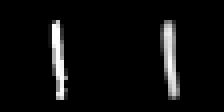

33580


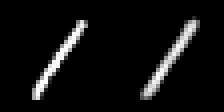

18493


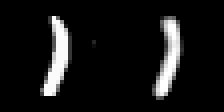

15521


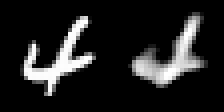

43657


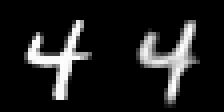

39304


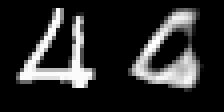

4003


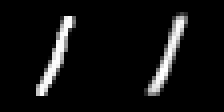

In [139]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print(index)
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test%d.png'%index, format="PNG")
    return IPdisplay(IPImage('data/test%d.png'%index))

# Ones
for i in [8,33580,18493]:
    compare_images(i)

# Fours
for i in [15521,43657,39304]:
    compare_images(i)

compare_images(np.random.randint(50000))

In [16]:
## we find the encode layer from our ae, and use it to define an encoding function

def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None
encode_layer, encode_layer_index = get_layer_by_name(ae, 'encode')

def encode_input(encode_layer, X):
    return get_output(encode_layer, inputs=X).eval()

X_encoded = encode_input(encode_layer, X.astype('float64'))


In [17]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

(1, 784)


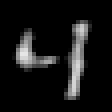

In [18]:
def get_output_from_nn(last_layer, X):
    return get_output(last_layer,X).eval()

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = 256 * decode_encoded_input(X_encoded[2])

X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print(X_decoded.shape)

pic_array = get_picture_array(X_decoded)
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

In [19]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [20]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i], rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

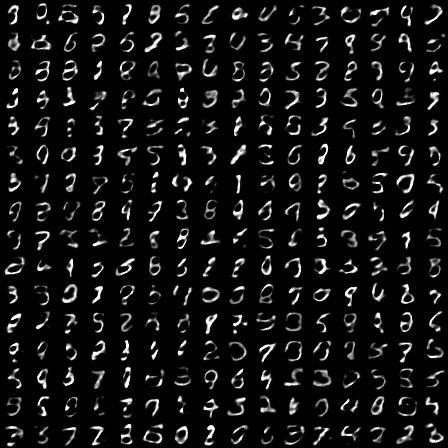

In [21]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')